In [0]:
from sympy.abc import a, c, x, y, z
import sympy as sp
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt

In [0]:
# OPERATIONAL CONSTANTS
class Constants:
  LINEAR = "linear"
  POLY_QUADRATIC = "quadratic"
  POLY_CUBIC = "cubic"
  STEP_CONSTANT = "jump"
  STEP_VARIABLE = "kink"
  INTERACTION_TWO_WAY = "interaction_two"
  INTERACTION_THREE_WAY = "interaction_three"

  COVARIATE_SYMBOLS_KEY = "covariates"
  EXPRESSION_KEY = "expr"

  SUBFUNCTION_FORMS = {
    LINEAR: {
        COVARIATE_SYMBOLS_KEY: [x],
        EXPRESSION_KEY: c*x
    },
    POLY_QUADRATIC: {
        COVARIATE_SYMBOLS_KEY: [x],
        EXPRESSION_KEY: c*(x**2)
    },
    POLY_CUBIC: {
        COVARIATE_SYMBOLS_KEY: [x],
        EXPRESSION_KEY: c*(x**3)
    },
    STEP_CONSTANT: {
        COVARIATE_SYMBOLS_KEY: [x],
        EXPRESSION_KEY: sp.Piecewise((0, x < a), (c, True))
    },
    STEP_VARIABLE: {
        COVARIATE_SYMBOLS_KEY: [x],
        EXPRESSION_KEY: sp.Piecewise((0, x < a), (c*x, True))
    },
    INTERACTION_TWO_WAY: {
        COVARIATE_SYMBOLS_KEY: [x, y],
        EXPRESSION_KEY: c*x*y
    },
    INTERACTION_THREE_WAY: {
        COVARIATE_SYMBOLS_KEY: [x, y, z],
        EXPRESSION_KEY: c*x*y*z
    },
  }

  SUBFUNCTION_CONSTANT_SYMBOLS = {a, c}

  TREATMENT_EFFECT_SYMBOL = sp.symbols("T")
  OUTCOME_NOISE_SYMBOL = sp.symbols("NOISE")

In [0]:
class Parameters:
  ### CONFOUNDER SETTINGS ##

  # Probability that a covariate is a potential confounder
  # (affecting one or both of treatment and outcome)
  # Lower values reduce the number of covariates which are predicitive
  # of treatment/outcome. This makes modelling harder given need
  # for variable selection.
  POTENTIAL_CONFOUNDER_SELECTION_PROBABILITY = 0.6

  # Probability that a covariate in the true space
  # will appear in both the outcome and treatment functions.
  # This is a soft target, with some room for variance.
  ACTUAL_CONFOUNDER_ALIGNMENT = 0.5

  ### SHARED TREAT/OUTCOME FUNCTION SETTINGS ###

  # Probabilities which govern the probability with which
  # covariates appear in the treatment mechanism in different
  # forms.
  TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY = {
    Constants.LINEAR: 0.5,
    Constants.POLY_QUADRATIC: 0.25,
    Constants.POLY_CUBIC: 0.05,
    Constants.STEP_CONSTANT: 0.01,
    Constants.STEP_VARIABLE: 0,
    Constants.INTERACTION_TWO_WAY: 0.7,
    Constants.INTERACTION_THREE_WAY: 0.02
  }

  OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY = {
    Constants.LINEAR: 0.5,
    Constants.POLY_QUADRATIC: 0.2,
    Constants.POLY_CUBIC: 0.07,
    Constants.STEP_CONSTANT: 0.05,
    Constants.STEP_VARIABLE: 0,
    Constants.INTERACTION_TWO_WAY: 0.11,
    Constants.INTERACTION_THREE_WAY: 0.04
  }
  
  @staticmethod
  def sample_subfunction_constants(size=1):
    # DF for the T-distribution over subfunction constants.
    SUBFUNCTION_CONSTANT_TAIL_THICKNESS = 3
    return np.round(np.random.standard_t(
               SUBFUNCTION_CONSTANT_TAIL_THICKNESS, size=size), 3)

  ### TREATMENT FUNCTION PARAMS ###

  # propensity score settings
  MIN_PROPENSITY_SCORE = 0.1
  MAX_PROPENSITY_SCORE = 0.9
  TARGET_PROPENSITY_SCORE = 0.65
  
  logistic_function = (sp.functions.exp(x)/(1+sp.functions.exp(x)))
  TARGET_MIN_LOGIT = sp.solve(logistic_function - MIN_PROPENSITY_SCORE, x)[0]
  TARGET_MAX_LOGIT = sp.solve(logistic_function - MAX_PROPENSITY_SCORE, x)[0]
  TARGET_MEAN_LOGIT = sp.solve(logistic_function - TARGET_PROPENSITY_SCORE, x)[0]

  ### OUTCOME FUNCTION PARAMS ###
  
  @staticmethod
  def sample_outcome_noise(size=1):
    # DF for the T-distribution over outcome noise.
    OUTCOME_NOISE_TAIL_THICKNESS = 3
    return np.round(np.random.standard_t(
              OUTCOME_NOISE_TAIL_THICKNESS, size=size), 3)
    
  # Treatment Effect

  # Marginal probability that there is an interaction between the
  # base treatment effect and each subfunction in the outcome function.
  TREATMENT_EFFECT_HETEROGENEITY = 0.3

  @staticmethod
  def sample_treatment_effect(size=1):
    # DF for the T-distribution over treatment effects.
    TREATMENT_EFFECT_TAIL_THICKNESS = 3
    return np.round(np.random.standard_t(
              TREATMENT_EFFECT_TAIL_THICKNESS, size=size), 3)

  # Marginal probability of observing any given row of the dataset.
  # Used to reduce the overall number of observations if desired.
  OBSERVATION_PROBABILITY = 1

In [0]:
# Utility functions

def select_given_probability_distribution(full_list, selection_probabilities):
  full_list = np.array(full_list)
  
  flat = len(full_list.shape) == 1
  if flat:
    full_list = full_list.reshape((-1, 1))

  selections = np.random.uniform(size=full_list.shape[0]) < selection_probabilities
  selected = full_list[selections, :]
  if flat:
    selected = selected.flatten()
  return selected, selections

def evaluate_expression(expression, data):
  free_symbols = list(expression.free_symbols)
  func = np.vectorize(sp.lambdify(
      free_symbols,
      expression,
      "numpy",
      dummify=False))
  
  covar_data = [data[[str(symbol)]].to_numpy() for symbol in free_symbols]
  return func(*covar_data).flatten()

@np.vectorize
def initialize_expression_constants(expression):
  constants_to_initialize = \
    Constants.SUBFUNCTION_CONSTANT_SYMBOLS.intersection(expression.free_symbols)

  return expression.subs(zip(constants_to_initialize,
                             Parameters.sample_subfunction_constants(
                                 size=len(constants_to_initialize))))

In [5]:
def build_data_frame(covar_data, covar_names):
  n_observations = covar_data.shape[0]
  
  # Build DF
  data = pd.DataFrame(
      data=covar_data,
      columns=covar_names,
      index=np.arange(n_observations))

  # Sample and add noise column
  noise_samples = Parameters.sample_outcome_noise(size=n_observations)
  data[str(Constants.OUTCOME_NOISE_SYMBOL)] = noise_samples

  # Sample observations to reduce observation count if desired.
  data = data.sample(frac=Parameters.OBSERVATION_PROBABILITY)

  # generate symbols for all covariates
  covar_symbols = np.array(sp.symbols(covar_names))

  return data, covar_symbols

N_COVARS = 20
N_OBSERVATIONS = 1000

# Generate random covariates and name sequentially
X = np.random.uniform(size=(N_OBSERVATIONS, N_COVARS))
COVAR_NAMES = np.array([f"X{i}" for i in range(N_COVARS)])

# Build data frame
data, covar_symbols = build_data_frame(X, list(COVAR_NAMES))

print(data.shape)
data.head()

(1000, 21)


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X11,X12,X13,X14,X15,X16,X17,X18,X19,NOISE
361,0.055421,0.389182,0.351241,0.568402,0.021001,0.121609,0.012659,0.257842,0.578047,0.582591,...,0.213451,0.038818,0.230067,0.535973,0.924800,0.905572,0.174132,0.668519,0.618595,-0.231
83,0.314630,0.629634,0.292800,0.909875,0.842571,0.641474,0.329640,0.327436,0.481733,0.042951,...,0.562559,0.831835,0.395983,0.587004,0.152084,0.230622,0.976890,0.404247,0.403405,3.780
225,0.530158,0.895908,0.656805,0.497613,0.374913,0.987452,0.275478,0.104951,0.168357,0.034319,...,0.413932,0.086320,0.140257,0.985601,0.909614,0.638450,0.793705,0.514122,0.811555,0.721
173,0.764406,0.671338,0.538660,0.867985,0.822150,0.376248,0.786164,0.406314,0.533859,0.211637,...,0.011701,0.917110,0.504175,0.422033,0.532834,0.407781,0.180987,0.858660,0.443543,-0.278
696,0.499676,0.019683,0.113357,0.187354,0.726480,0.819126,0.379010,0.410434,0.795781,0.219159,...,0.676058,0.959655,0.644208,0.732995,0.826108,0.326648,0.959514,0.902983,0.096451,-0.420


### 1) Select Potential Confounders

In [6]:
potential_confounder_symbols, potential_confounder_selections = select_given_probability_distribution(
    full_list=covar_symbols,
    selection_probabilities=Parameters.POTENTIAL_CONFOUNDER_SELECTION_PROBABILITY)

potential_confounder_symbols

array([X2, X3, X4, X5, X6, X7, X8, X11, X13, X16, X18, X19], dtype=object)

### 2) Create new covariate spaces for Treat/Outcome

This stage determines the linearity of the functions

In [0]:
def generate_transformed_covariate_space(covariate_symbols, subfunction_form_probabilities):
  subfunctions = []
  for subfunction_form_name, subfunction_form in Constants.SUBFUNCTION_FORMS.items():
    subfunc_expression = subfunction_form[Constants.EXPRESSION_KEY]
    subfunc_covariate_symbols = subfunction_form[Constants.COVARIATE_SYMBOLS_KEY]

    # All possible combinations of covariates for the given subfunc.
    covariate_combinations = np.array(list(combinations(covariate_symbols,
                                        len(subfunc_covariate_symbols))))
  
    selected_covar_combinations, _ = select_given_probability_distribution(
      full_list=covariate_combinations,
      selection_probabilities=subfunction_form_probabilities[subfunction_form_name])
    
    
    subfunctions.extend([ 
                          subfunc_expression.subs(
                              zip(subfunc_covariate_symbols, covar_comb))
                          for covar_comb in selected_covar_combinations
                        ])

  
  return subfunctions

In [0]:
def generate_aligned_treatment_and_outcome_covariates(covariate_symbols):
  true_outcome_covariates = generate_transformed_covariate_space(
      covariate_symbols,
      Parameters.OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY)

  true_treatment_covariates = generate_transformed_covariate_space(
      covariate_symbols,
      Parameters.TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY)

  # Unique set of all covariates
  true_covariates = np.array(list(set(true_treatment_covariates + true_outcome_covariates)))
  
  # Select overlapping covariates (confounders) given alignment
  # parameter.
  shared_confounders, _ = select_given_probability_distribution(
      true_covariates,
      selection_probabilities=Parameters.ACTUAL_CONFOUNDER_ALIGNMENT)
  shared_confounders = set(shared_confounders)

  # Union the true confounders into the original covariate selections.
  true_outcome_covariates = list(shared_confounders.union(true_outcome_covariates))
  true_treatment_covariates = list(shared_confounders.union(true_treatment_covariates))

  return true_outcome_covariates, true_treatment_covariates

true_outcome_covariates, true_treatment_covariates = \
  generate_aligned_treatment_and_outcome_covariates(potential_confounder_symbols)

### 3) Create Treatment Function

In [0]:
def generate_treatment_function(treatment_subfunctions, data):
  # TODO: consider recursively applying the covariate transformation
  # to produce "deep" functions. Probability overkill.

  # TODO: enable overlap adjustment

  # Randomly initialize subfunction constants
  initialized_subfunctions = initialize_expression_constants(treatment_subfunctions)

  # Build base treatment logit function. Additive combination of the true covariates.
  # TODO: add non-linear activation function
  base_treatment_logit_expression = np.sum(initialized_subfunctions)

  # Sample data to evaluate distribution.
  sampled_data = data.sample(frac=0.25)

  # Adjust logit
  logit_values = evaluate_expression(base_treatment_logit_expression, sampled_data)
  max_logit = np.max(logit_values)
  min_logit = np.min(logit_values)
  mean_logit = np.mean(logit_values)

  # Rescale to meet min/max constraints and target propensity.
  # First, construct function to rescale between 0 and 1
  normalized_logit_expr = (x - min_logit)/(max_logit - min_logit)
  
  # Second, construct function to rescale to target interval
  constrained_logit_expr = Parameters.TARGET_MIN_LOGIT + \
    (x*(Parameters.TARGET_MAX_LOGIT - Parameters.TARGET_MIN_LOGIT))

  rescaling_expr = constrained_logit_expr.subs(x, normalized_logit_expr)
  rescaled_logit_mean = rescaling_expr.evalf(subs={x: mean_logit})

  # Third, construct function to apply offset for targeted propensity.
  # This requires the rescaled mean found above.
  target_propensity_adjustment = Parameters.TARGET_MEAN_LOGIT - rescaled_logit_mean
  targeted_logit_expr = rescaling_expr + target_propensity_adjustment

  # Apply max/min truncation to account for adjustment shift.
  max_min_capped_targeted_logit = sp.functions.Max(
      sp.functions.Min(targeted_logit_expr, Parameters.TARGET_MAX_LOGIT),
      Parameters.TARGET_MIN_LOGIT)
  
  # Finally, construct the full function expression.
  treatment_logit_expr = max_min_capped_targeted_logit.subs(
      x, base_treatment_logit_expression)
  exponentiated_logit = sp.functions.exp(treatment_logit_expr)
  logistic_function = exponentiated_logit/(1 + exponentiated_logit)

  return logistic_function

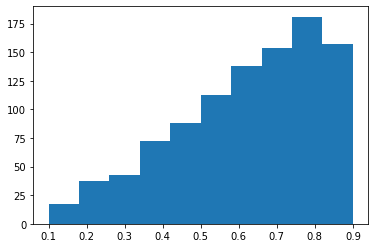

In [10]:
treatment_function = generate_treatment_function(true_treatment_covariates, data)
vals = evaluate_expression(treatment_function, data)
plt.hist(vals)

plt.show()

### 4) Create outcome function

In [0]:
def generate_treatment_effect_subfunction(outcome_subfunctions, data):
  base_treatment_effect = Parameters.sample_treatment_effect()[0]
  
  # Sample outcome subfunctions to interact with Treatment effect.
  selected_interaction_terms, _ = select_given_probability_distribution(
      full_list=outcome_subfunctions,
      selection_probabilities=Parameters.TREATMENT_EFFECT_HETEROGENEITY)
  
  # Build multiplier
  treatment_effect_multiplier_expr = np.sum(selected_interaction_terms)

  # Normalize multiplier size but not location. This keeps the size
  # of the effect bounded but doesn't center the effect for different units
  # at 0.
  sampled_data = data.sample(frac=0.25)
  treatment_effect_multiplier_values = evaluate_expression(treatment_effect_multiplier_expr, sampled_data)
  multiplier_std = np.std(treatment_effect_multiplier_values)
  multiplier_mean = np.mean(treatment_effect_multiplier_values)
  normalized_treatment_effect_multiplier_expr = (treatment_effect_multiplier_expr - multiplier_mean)/multiplier_std

  treatment_effect_subfunction = base_treatment_effect*(1+normalized_treatment_effect_multiplier_expr)

  return treatment_effect_subfunction

def generate_outcome_function(outcome_subfunctions, data):
  # TODO: consider recursively applying the covariate transformation
  # to produce "deep" functions. Probability overkill.

  # Randomly initialize subfunction constants
  initialized_subfunctions = initialize_expression_constants(outcome_subfunctions)

  # Build base outcome function. Additive combination of the true covariates.
  # TODO: add non-linear activation function
  base_outcome_expression = np.sum(initialized_subfunctions)

  # Sample data to evaluate distribution.
  sampled_data = data.sample(frac=0.25)

  # Normalized outcome values to have approximate mean=0 and std=1.
  # This prevents situations where large outcome values drown out
  # the treatment effect or the treatment effect dominates small average outcomes.
  outcome_values = evaluate_expression(base_outcome_expression, sampled_data)
  outcome_mean = np.mean(outcome_values)
  outcome_std = np.std(outcome_values)

  # This is only an approximate normalization. It will shift the mean to zero
  # but the exact effect on std will depend on the distribution.
  normalized_outcome_expression = (base_outcome_expression - outcome_mean)/outcome_std

  # Create the treatment effect subfunction.
  treatment_effect_expression = generate_treatment_effect_subfunction(
      initialized_subfunctions, data)
  
  response_surface_expression = normalized_outcome_expression + \
    Constants.TREATMENT_EFFECT_SYMBOL*treatment_effect_expression + \
    Constants.OUTCOME_NOISE_SYMBOL
  
  return response_surface_expression

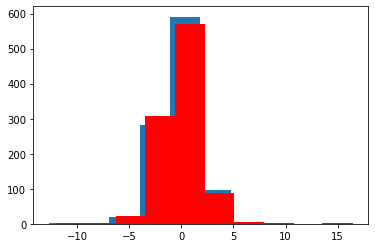

In [12]:
outcome_function = generate_outcome_function(true_outcome_covariates, data)

vals = evaluate_expression(outcome_function.subs(Constants.TREATMENT_EFFECT_SYMBOL, 1), data)
plt.hist(vals)
vals = evaluate_expression(outcome_function.subs(Constants.TREATMENT_EFFECT_SYMBOL, 0), data)
plt.hist(vals, color="r")

plt.show()

In [13]:
def simulate_treatment_and_potential_outcomes(treatment_function, outcome_function, data):
  n_observations = data.shape[0]

  simulated_data = data.copy()

  propensity_scores = evaluate_expression(treatment_function, data)
  T = (np.random.uniform(size=n_observations) < propensity_scores).astype(int)

  simulated_data["T"] = T

  Y0 = evaluate_expression(
      outcome_function.subs(Constants.TREATMENT_EFFECT_SYMBOL, 0), data)
  Y1 = evaluate_expression(
      outcome_function.subs(Constants.TREATMENT_EFFECT_SYMBOL, 1), data)
  simulated_data["Y0"] = Y0
  simulated_data["Y1"] = Y1
  
  Y = (T*Y1) + ((1-T)*Y0)
  simulated_data["Y"] = Y

  treatment_effect = Y1 - Y0
  simulated_data["treatment_effect"] = treatment_effect

  return simulated_data

simulated_data = simulate_treatment_and_potential_outcomes(treatment_function, outcome_function, data)
simulated_data.head(n=10)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X16,X17,X18,X19,NOISE,T,Y0,Y1,Y,treatment_effect
361,0.055421,0.389182,0.351241,0.568402,0.021001,0.121609,0.012659,0.257842,0.578047,0.582591,...,0.905572,0.174132,0.668519,0.618595,-0.231,0,-0.038013,0.027950,-0.038013,0.065964
83,0.314630,0.629634,0.292800,0.909875,0.842571,0.641474,0.329640,0.327436,0.481733,0.042951,...,0.230622,0.976890,0.404247,0.403405,3.780,0,4.261090,3.835915,4.261090,-0.425175
225,0.530158,0.895908,0.656805,0.497613,0.374913,0.987452,0.275478,0.104951,0.168357,0.034319,...,0.638450,0.793705,0.514122,0.811555,0.721,1,0.837404,0.822531,0.822531,-0.014874
173,0.764406,0.671338,0.538660,0.867985,0.822150,0.376248,0.786164,0.406314,0.533859,0.211637,...,0.407781,0.180987,0.858660,0.443543,-0.278,1,0.528153,0.050479,0.050479,-0.477674
696,0.499676,0.019683,0.113357,0.187354,0.726480,0.819126,0.379010,0.410434,0.795781,0.219159,...,0.326648,0.959514,0.902983,0.096451,-0.420,0,0.100585,-0.137750,0.100585,-0.238334
463,0.697616,0.749700,0.182916,0.310261,0.835847,0.764147,0.993279,0.332507,0.720743,0.206869,...,0.539787,0.373714,0.486897,0.960542,1.189,1,2.581066,1.921009,1.921009,-0.660057
231,0.074168,0.579774,0.145536,0.637524,0.890435,0.417017,0.654808,0.398529,0.471661,0.919791,...,0.429511,0.598018,0.458901,0.407896,-0.813,0,0.694832,-0.207056,0.694832,-0.901888
613,0.188882,0.349615,0.007696,0.911981,0.221596,0.903265,0.982596,0.803253,0.028588,0.524692,...,0.175448,0.109085,0.851230,0.083848,0.093,0,-0.203283,-0.689805,-0.203283,-0.486522
979,0.669670,0.569248,0.602573,0.042748,0.434523,0.151553,0.683239,0.679201,0.529252,0.180137,...,0.782627,0.501515,0.825465,0.617596,1.294,1,-0.339456,-0.716030,-0.716030,-0.376574
916,0.113447,0.147755,0.865975,0.349444,0.349720,0.591536,0.486539,0.692550,0.090247,0.569364,...,0.698904,0.511205,0.129474,0.955581,0.169,1,-0.578888,-0.648305,-0.648305,-0.069417


(1000, 21)


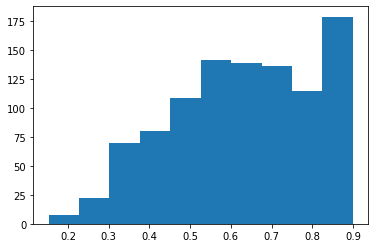

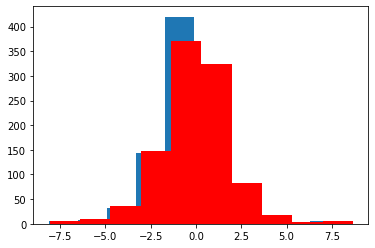

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X16,X17,X18,X19,NOISE,T,Y0,Y1,Y,treatment_effect
520,0.655211,0.559855,0.434394,0.339417,0.830736,0.837797,0.428737,0.905336,0.785778,0.667150,...,0.773193,0.547116,0.165550,0.524253,-0.826,1,-1.825244,-2.284748,-2.284748,-0.459504
940,0.949646,0.080229,0.466481,0.012008,0.846114,0.268551,0.419388,0.432435,0.297820,0.970916,...,0.427378,0.305630,0.749299,0.436015,0.263,1,0.687173,0.133278,0.133278,-0.553895
619,0.424068,0.058112,0.766068,0.860756,0.804959,0.590303,0.464329,0.806089,0.599059,0.116607,...,0.425621,0.211093,0.269400,0.233131,-0.829,1,-0.642190,-1.136541,-1.136541,-0.494351
265,0.674573,0.411335,0.812361,0.843880,0.359621,0.950656,0.800283,0.028842,0.617271,0.062067,...,0.979181,0.629342,0.545505,0.720314,-0.162,0,-1.793705,-2.220787,-1.793705,-0.427082
301,0.039716,0.580842,0.931370,0.401097,0.203523,0.150990,0.588144,0.916699,0.376521,0.312784,...,0.938357,0.242036,0.737145,0.345362,7.826,1,7.194760,7.172373,7.172373,-0.022388
779,0.224803,0.555863,0.269350,0.095648,0.423258,0.910757,0.496885,0.342356,0.409532,0.492769,...,0.357507,0.796014,0.573945,0.659006,-0.804,0,-0.298155,-1.011393,-0.298155,-0.713239
913,0.499111,0.473653,0.310469,0.800610,0.213465,0.847161,0.265808,0.040738,0.826181,0.988597,...,0.763184,0.554535,0.493765,0.584359,-0.410,1,-2.176519,-2.382732,-2.382732,-0.206213
960,0.771067,0.497817,0.866156,0.956439,0.840567,0.978020,0.718116,0.317106,0.434147,0.843293,...,0.456486,0.644018,0.923307,0.576819,1.044,0,1.023421,0.596638,1.023421,-0.426782
500,0.779285,0.569397,0.709822,0.473221,0.148591,0.042125,0.178262,0.694990,0.341240,0.876065,...,0.349901,0.680465,0.112639,0.805565,1.193,1,0.967349,0.810167,0.810167,-0.157182
746,0.221924,0.207333,0.865330,0.460006,0.475052,0.199030,0.300349,0.013364,0.953848,0.289214,...,0.910560,0.346630,0.302273,0.295544,-0.300,0,-1.600046,-2.216225,-1.600046,-0.616179


In [14]:
N_COVARS = 20
N_OBSERVATIONS = 1000

# Generate random covariates and name sequentially
X = np.random.uniform(size=(N_OBSERVATIONS, N_COVARS))
COVAR_NAMES = np.array([f"X{i}" for i in range(N_COVARS)])

# Build data frame
data, covar_symbols = build_data_frame(X, list(COVAR_NAMES))

print(data.shape)
data.head()

############################

potential_confounder_symbols, potential_confounder_selections = select_given_probability_distribution(
    full_list=covar_symbols,
    selection_probabilities=Parameters.POTENTIAL_CONFOUNDER_SELECTION_PROBABILITY)

potential_confounder_symbols

############################

treatment_function = generate_treatment_function(true_treatment_covariates, data)
vals = evaluate_expression(treatment_function, data)
plt.hist(vals)

plt.show()

###########################

outcome_function = generate_outcome_function(true_outcome_covariates, data)

vals = evaluate_expression(outcome_function.subs(Constants.TREATMENT_EFFECT_SYMBOL, 1), data)
plt.hist(vals)
vals = evaluate_expression(outcome_function.subs(Constants.TREATMENT_EFFECT_SYMBOL, 0), data)
plt.hist(vals, color="r")

plt.show()

###########################

simulated_data = simulate_treatment_and_potential_outcomes(treatment_function, outcome_function, data)
simulated_data.head(n=10)